In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/02620')

Mounted at /content/drive/


In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
brca = pd.read_csv('BRCA.txt', sep='\t').transpose()

In [4]:
brca.head()

,ENSG00000242268.2,ENSG00000172137.17,ENSG00000240423.1,ENSG00000269416.4,ENSG00000218358.2,ENSG00000164283.11,ENSG00000259345.4,ENSG00000036448.8,ENSG00000258116.1,ENSG00000101323.4,...,ENSG00000215644.8,ENSG00000273542.1,ENSG00000276831.1,ENSG00000148704.11,ENSG00000258179.1,ENSG00000233147.1,ENSG00000248869.4,ENSG00000233966.1,ENSG00000230853.1,ENSG00000135094.9
TCGA-E9-A1NI-01A,0.091708,2.438029,0.026351,0.088983,0.102633,3.276272,0.109765,0.042214,0.068942,0.000000,...,0.100155,0.606664,0.185812,0.000000,0.000000,0.000000,0.000000,0.503775,0.0,2.478451
TCGA-A1-A0SP-01A,0.000000,0.649640,0.037628,0.314071,1.252716,1.357046,0.014787,0.577137,0.506927,0.013495,...,0.007415,0.279897,0.069378,0.004157,0.000000,0.000000,0.072839,2.355847,0.0,1.148413
TCGA-BH-A1EU-11A,0.057899,3.749056,0.325404,0.062266,0.043580,0.294604,0.111980,0.579210,0.000000,0.000000,...,0.000000,0.128538,0.000000,0.007229,0.150186,0.293227,1.119001,0.000000,0.0,0.389017
TCGA-A8-A06X-01A,0.000000,0.175693,0.000000,0.000000,0.431859,1.674190,0.105125,0.160897,0.000000,0.000000,...,0.010867,0.394155,0.283167,0.000000,0.000000,0.000000,0.000000,1.018379,0.0,2.830691
TCGA-E2-A14T-01A,0.000000,2.229444,0.000000,0.763435,0.062730,0.924285,1.698773,0.229158,0.036029,0.000000,...,0.000000,1.961064,0.098978,0.000000,0.064086,0.000000,0.008947,1.548529,0.0,2.636358


In [5]:
n_feature = brca.shape[1]

In [6]:
sample_name = []
for row in brca.index:
    sample_name.append(row)


In [7]:
y = []
for s in sample_name:
  if s[-3:] == '11A':
    y.append(1)
  else:
    y.append(0)


In [8]:
sum(y)

99

In [9]:
from sklearn import model_selection
x_train,x_test,y_train,y_test= model_selection.train_test_split(brca.values,
                                                y,
                                                test_size=0.2,
                                                random_state=3,
                                                stratify=y,
                                                shuffle=True)

In [10]:
x_train.dtype

dtype('float64')

In [11]:
from collections import Counter
count=Counter(y_train)
class_count=np.array([count[0],count[1]])
weight=1./class_count
print(weight)

[0.00115875 0.01265823]


In [12]:
samples_weight = np.array([weight[t] for t in y_train])

In [13]:
samples_weight=torch.from_numpy(samples_weight)

In [14]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))

In [15]:
batch_size = 10

In [16]:
trainDataset = torch.utils.data.TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
validDataset = torch.utils.data.TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test))
trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=batch_size, num_workers=1, sampler = sampler)
testLoader = torch.utils.data.DataLoader(dataset = validDataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [17]:
import torch.nn.functional as F

In [18]:
class predictor(torch.nn.Module):
    def __init__(self,n_input,n_output):
        super().__init__()
        self.hidden1 = torch.nn.Linear(n_input,n_input//8)
        self.hidden2 = torch.nn.Linear(n_input//8,n_input//16)
        self.hidden3 = torch.nn.Linear(n_input//16,n_output)
    def forward(self, input):
        out = self.hidden1(input)
        out = torch.sigmoid(out)
        out = self.hidden2(out)
        out = torch.sigmoid(out)
        out = self.hidden3(out)
        return out

In [19]:
model = predictor(n_feature,  2)
cuda0 = torch.device('cuda:0')
model = model.to(cuda0)

In [20]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()


In [21]:
from IPython.display import clear_output
def draw_pics(loss_test_list, loss_train_list, acc_test_list, acc_train_list):
    clear_output(wait=True)
    fig,a =  plt.subplots(1,2, figsize=(24,10))

    a[0].plot(loss_test_list, label = 'Test set')
    a[0].plot(loss_train_list, label = 'Training set')
    a[0].set_title('Loss')
    a[0].legend(loc="upper right")
    
  

    a[1].plot(acc_test_list, label = 'Test set')
    a[1].plot(acc_train_list, label = "Training set")
    a[1].set_title('Accuracy')
    a[1].legend(loc="upper right")

    plt.show()

In [22]:
def evaluate_loss(model, criterion, testLoader, trainLoader):
    model.eval()
    with torch.no_grad():
      loss_test = []
      loss_train = []
      for batch_test in testLoader:
          prediction = model(F.normalize(batch_test[0]).to(cuda0))
          loss_test.append(criterion(prediction, batch_test[1].to(cuda0)))
      for batch_train in trainLoader:
          prediction = model(F.normalize(batch_train[0]).to(cuda0))
          loss_train.append(criterion(prediction, batch_train[1].to(cuda0)))  
    loss_test_epoch = sum(loss_test) /len(loss_test)
    loss_train_epoch = sum(loss_train)/len(loss_train)
    return loss_test_epoch, loss_train_epoch

In [23]:
def evaluate_accuracy(model, criterion, testLoader, trainLoader):
    model.eval()
    with torch.no_grad():
      acc_test = []
      acc_train = []
      for batch_test in testLoader:
          prediction = model(F.normalize(batch_test[0]).to(cuda0))
          binary_pre = []
          for i in range(len(prediction)):
              if prediction[i,0] > prediction[i,1]:
                  binary_pre.append(0)
              else:
                  binary_pre.append(1)
          y = batch_test[1].cpu().detach().numpy()
          binary_pre = np.array(binary_pre)
          accuracy = sum(binary_pre==y)/len(y)
          acc_test.append(accuracy)
      for batch_train in trainLoader:
          prediction = model(F.normalize(batch_train[0]).to(cuda0))
          binary_pre = []
          for i in range(len(prediction)):
              if prediction[i,0] > prediction[i,1]:
                  binary_pre.append(0)
              else:
                  binary_pre.append(1)
          y = batch_train[1].cpu().detach().numpy()
          binary_pre = np.array(binary_pre)
          accuracy = sum(binary_pre==y)/len(y)
          acc_train.append(accuracy)
      return sum(acc_test)/len(acc_test), sum(acc_train)/len(acc_train)
      



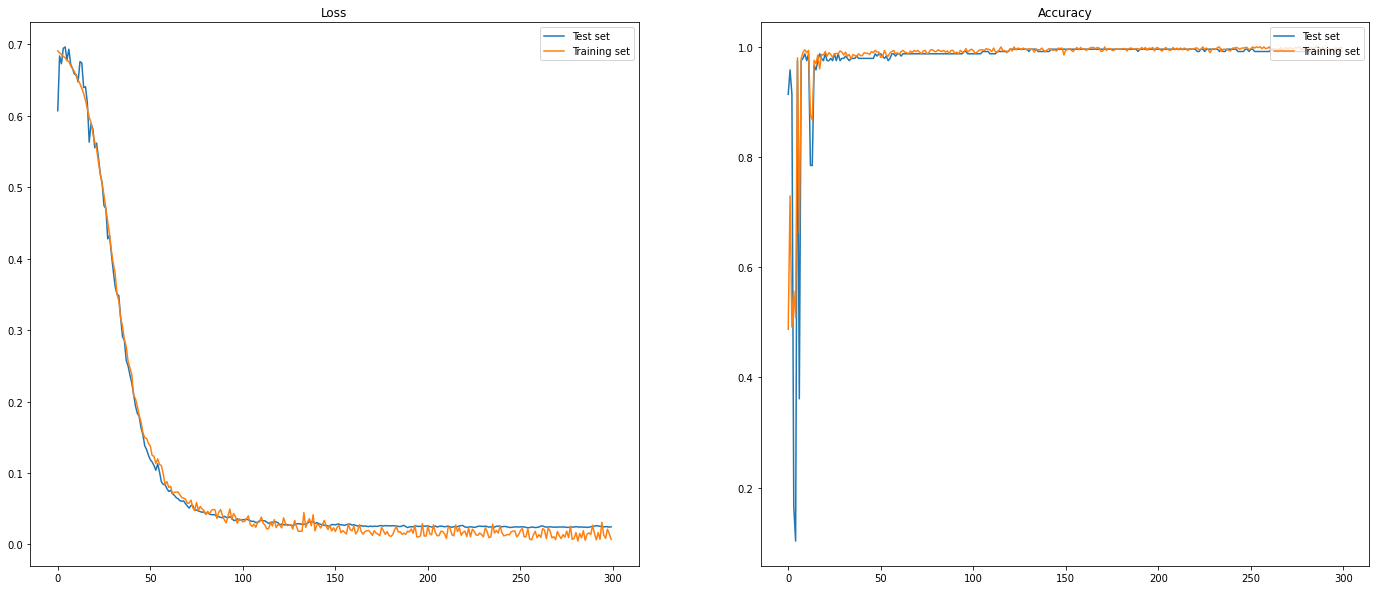

In [24]:
#先sample training set 和 test set选择参数
num_epochs = 300
loss_test_all = []
loss_train_all = []
acc_test_all = []
acc_train_all = []
for epoch in range(num_epochs):
    model.train()
    for idx, batch in enumerate(trainLoader):
        batch_x = F.normalize(batch[0])
        batch_x = batch_x.to(cuda0)
        batch_y = batch[1].to(cuda0)
        prediction = model(batch_x)

        loss = criterion(prediction, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    loss_test_epoch, loss_train_epoch =evaluate_loss(model, criterion, testLoader, trainLoader)
    loss_test_all.append(loss_test_epoch.item())
    loss_train_all.append(loss_train_epoch.item())
    acc_test_epoch, acc_train_epoch = evaluate_accuracy(model, criterion, testLoader, trainLoader)
    acc_test_all.append(acc_test_epoch)
    acc_train_all.append(acc_train_epoch)

    draw_pics(loss_test_all, loss_train_all, acc_test_all, acc_train_all)
    

In [25]:
model.to('cpu')
model.eval()
prediction = model(F.normalize(torch.tensor(brca.values[:,0:n_feature])).float())

In [26]:
binary_pre = []
for i in range(len(prediction)):
    if prediction[i,0] > prediction[i,1]:
        binary_pre.append(0)
    else:
        binary_pre.append(1)

In [27]:
binary_pre = np.array(binary_pre)
y = np.array(y)
accuracy = sum(binary_pre==y)/len(y)
print(accuracy)

0.9940577249575552


In [28]:
test_iter = iter(testLoader)
init = next(test_iter)
test_x = init[0]
test_y = init[1]
for i in test_iter:
    test_x = torch.cat((test_x, i[0]))
    test_y = torch.cat((test_y, i[1]))
test_y = test_y.tolist()

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from prettytable import PrettyTable
import warnings
prediction_2 = model(F.normalize(test_x).float())
binary_pre_2 = []
for i in range(len(prediction_2)):
    if prediction_2[i,0] > prediction_2[i,1]:
        binary_pre_2.append(0)
    else:
        binary_pre_2.append(1)

In [30]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
MCCs = []
auROCs = []
auPRCs = []

accuracy_scores.append(accuracy_score(y_true=test_y, y_pred= binary_pre_2))
f1_scores.append(f1_score(y_true=test_y, y_pred= binary_pre_2))
recall_scores.append(recall_score(y_true=test_y, y_pred= binary_pre_2))
precision_scores.append(precision_score(y_true=test_y, y_pred= binary_pre_2))
MCCs.append(matthews_corrcoef(y_true=test_y, y_pred= binary_pre_2))
# auROCs.append(roc_auc_score(y_true=y_test, y_score=clf.predict_sample(X_test,clf.Tree)[:, 1]))
# auPRCs.append(average_precision_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 0]))

table = PrettyTable()
column_names = ['Accuracy', 'auROC', 'auPRC', 'recall', 'precision', 'f1', 'MCC']
table.add_column(column_names[0], np.round(accuracy_scores, 4))
# table.add_column(column_names[1], np.round(auROCs, 4))
# table.add_column(column_names[2], np.round(auPRCs, 4))
table.add_column(column_names[3], np.round(recall_scores, 4))
table.add_column(column_names[4], np.round(precision_scores, 4))
table.add_column(column_names[5], np.round(f1_scores, 4))
table.add_column(column_names[6], np.round(MCCs, 4))

print(table)

+----------+--------+-----------+------+--------+
| Accuracy | recall | precision |  f1  |  MCC   |
+----------+--------+-----------+------+--------+
|  0.9915  |  0.95  |    0.95   | 0.95 | 0.9454 |
+----------+--------+-----------+------+--------+
